<center>
    <h2> Natural Language Processing (CS60075) </h2>
    <h3> Assignment - 2<br/>
         Bbiswabasu Roy<br/>
         19EC39007
    </h3>
</center>

<h3>Import libraries and reading input file</h3>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchtext
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from bs4 import BeautifulSoup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df = df.sample(frac=1, random_state=39).reset_index(drop=True)
df.head(10)

,review,sentiment
0,This is a very well done film showing the life...,positive
1,Not to be confused with the above average supe...,negative
2,"""It's funny your worst nightmare always seems ...",positive
3,<br /><br />In the process of boring you with ...,negative
4,Unfortunately this is not as good as any of th...,negative
5,"being a NI supporter, it's hard to objectively...",negative
6,waste of 1h45 this nasty little film is one to...,negative
7,I gave this movies a 7 out of 10. I think the ...,positive
8,"Watching It Lives By Night makes you wonder, j...",negative
9,at first I had the reaction a lot of people le...,positive


<h3>Preprocessing to remove unwanted content from reviews column</h3>

In [4]:
stopword_list=nltk.corpus.stopwords.words('english')
stopword_list.append(' ')

#Removing html
print("Removing html ...")
df['review'] = df['review'].str.replace('<br />','')

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', ' ', text)

df['review'] = df['review'].apply(remove_between_square_brackets)

#Remove special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern,' ',text)
    return text
df['review'] = df['review'].apply(remove_special_characters)

#Convert words to lower case
df['review'] = df['review'].str.lower()

print("Applying lemmatizer ...")
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])
df['review'] = df['review'].apply(lemmatize_text)

print("Removing stopwords ...")
#removing the stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
df['review'] = df['review'].apply(remove_stopwords)


df.head(10)

Removing html ...
Applying lemmatizer ...
Removing stopwords ...


,review,sentiment
0,well done film showing life international stud...,positive
1,confused average supernatural thriller sentine...,negative
2,funny worst nightmare always seems far away da...,positive
3,process boring wordy rambling storyline comple...,negative
4,unfortunately good film jim carrey producing s...,negative
5,ni supporter hard objectively review movie glo...,negative
6,waste h nasty little film one avoid like cheap...,negative
7,gave movie think general dislike movie due peo...,positive
8,watching life night make wonder world greenlit...,negative
9,first reaction lot people left seeing shot fat...,positive


<h3>Split data into train, dev and test set</h3>

In [5]:
train_size = int(len(df)*0.8)
dev_size = int(len(df)*0.1)

train_reviews = df['review'][:train_size]
train_sentiments = df['sentiment'][:train_size]

dev_reviews = df['review'][train_size:train_size+dev_size]
dev_sentiments = df['sentiment'][train_size:train_size+dev_size]

test_reviews = df['review'][train_size+dev_size:]
test_sentiments = df['sentiment'][train_size+dev_size:]

In [6]:
corpus = []
token2id = dict()
id2token = dict()

for text in train_reviews.values:
    words = word_tokenize(text)
    for word in words:
        if word not in token2id:
            token2id[word] = len(token2id)+1
            id2token[len(token2id)] = word
    corpus.append(words)
token2id['<UNK>'] = len(token2id)+1
id2token[len(token2id)] = '<UNK>'
print("Vocabulary size: ", len(token2id))

Vocabulary size:  84326


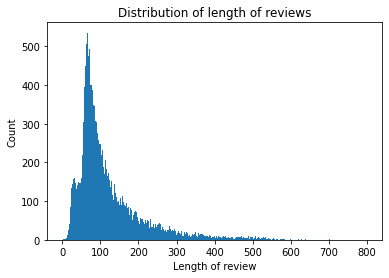

In [7]:
import matplotlib.pyplot as plt

plt.hist([len(sent) for sent in corpus],bins=[i for i in range(800)])
plt.title("Distribution of length of reviews")
plt.xlabel("Length of review")
plt.ylabel("Count")
plt.show()

<h3>Convert text to numerical values and compute embedding matrix using GloVe</h3>

In [8]:
def texts_to_sequences(texts):
    sequences = []
    i=0
    for text in texts:
        sequence = []
        words = word_tokenize(text)
        for word in words:
            if word not in token2id:
                word = '<UNK>'
            sequence.append(token2id[word])
        sequences.append(sequence)
    return sequences
            
def pad_sequences(sequences, seq_len):
    for i in range(len(sequences)):
        seq = sequences[i]
        if len(seq)>seq_len:
            seq = seq[-seq_len:]
        while len(seq)!=seq_len:
            seq = [0] + seq
        sequences[i] = seq
    return sequences

In [9]:
# Hyper-parameters
embed_dim = 300
hidden_dim = 200
seq_len = 200
epochs = 7
vocab_size = len(token2id)
train_batch_size = 128
test_batch_size = 128
learning_rate = 1e-3

In [10]:
train_reviews = texts_to_sequences(train_reviews)
train_reviews = pad_sequences(train_reviews,seq_len)

dev_reviews = texts_to_sequences(dev_reviews)
dev_reviews = pad_sequences(dev_reviews,seq_len)

test_reviews = texts_to_sequences(test_reviews)
test_reviews = pad_sequences(test_reviews,seq_len)

In [11]:
print(train_reviews[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 3, 23, 24, 25, 26, 27, 28, 29, 30, 31, 19, 26, 32, 8, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 28, 43, 44, 45, 46, 37, 47, 48, 49, 50, 51, 52, 53, 54, 37, 55, 37, 56, 47, 57, 58, 51, 59, 7, 60, 5, 61, 62, 63]


In [12]:
def label_to_num(sentiments):
    labels = []
    for i in range(len(sentiments)):
        if sentiments[i]=='positive':
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [13]:
train_sentiments = label_to_num(train_sentiments.values)
dev_sentiments = label_to_num(dev_sentiments.values)
test_sentiments = label_to_num(test_sentiments.values)

In [14]:
print('Vocabulary size:',len(token2id))

Vocabulary size: 84326


In [15]:
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.LongTensor(train_reviews),torch.LongTensor(train_sentiments)), batch_size=train_batch_size, shuffle=True, drop_last=True)
dev_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.LongTensor(dev_reviews),torch.LongTensor(dev_sentiments)), batch_size=test_batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.LongTensor(test_reviews),torch.LongTensor(test_sentiments)), batch_size=test_batch_size, shuffle=False, drop_last=True)

In [16]:
glove = torchtext.vocab.GloVe(name='840B', dim=embed_dim)

In [17]:
# build weights matrix from GloVe
not_found = 0
weights_matrix = torch.zeros((vocab_size+1, embed_dim))
for word, idx in token2id.items():
    if not torch.equal(glove[word], torch.zeros(embed_dim)): 
        weights_matrix[idx] = glove[word]
    else:
        not_found+=1
        if not_found<=10:
            print(word)
        weights_matrix[idx] = torch.zeros((embed_dim))
print(f'{not_found} tokens not found in glove')

halfassing
dynocorpe
nekromantik
todesking
buttgereit
schopenhauerian
siebenmal
ingemar
croneberg
coutard
20652 tokens not found in glove


<h3> Building Model starts here <h3>

In [18]:
class SentimentRNN(nn.Module):
    def __init__(self):
        super(SentimentRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(weights_matrix)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, bidirectional=True, batch_first=True)       
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden,test=False):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        out = torch.cat((hidden[0][0], hidden[0][1]), dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros((2,batch_size,hidden_dim)).to(device)
        c0 = torch.zeros((2,batch_size,hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [19]:
model = SentimentRNN()
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

SentimentRNN(
  (embedding): Embedding(84326, 300)
  (lstm): LSTM(300, 200, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=400, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [20]:
def f1_score(pred,label):
    pred = torch.round(pred.squeeze())
    tp, fp, fn = 0, 0, 0
    for i in range(len(pred)):
        tp += ((pred[i]==1) & (label[i]==1)).float()
        fp += ((pred[i]==1) & (label[i]==0)).float()
        fn += ((pred[i]==0) & (label[i]==1)).float()
    return (tp, fp, fn)

<h3> Model training starts here (Do not run this cell if you just want to load model and test)</h3>

In [ ]:
clip = 5
epoch_tr_loss,epoch_dv_loss = [],[]
epoch_tr_score,epoch_dv_score = [],[]
for epoch in range(epochs):
    print(f'Epoch {epoch+1} ...') 
    train_losses = []
    train_tp, train_fp, train_fn = 0, 0, 0
    model.train()
    h = model.init_hidden(train_batch_size)
    for inputs, labels in train_iter:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        cur_scores = f1_score(output,labels)
        train_tp += cur_scores[0]
        train_fp += cur_scores[1]
        train_fn += cur_scores[2]
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    train_score = train_tp/(train_tp+0.5*(train_fp+train_fn))
    
    dev_h = model.init_hidden(test_batch_size)
    dev_losses = []
    dev_tp, dev_fp, dev_fn = 0, 0, 0
    model.eval()
    for inputs, labels in dev_iter:
        dev_h = tuple([each.data for each in dev_h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, dev_h = model(inputs, dev_h)
        dev_loss = criterion(output.squeeze(), labels.float())
        dev_losses.append(dev_loss.item())
        cur_scores = f1_score(output,labels)
        dev_tp += cur_scores[0]
        dev_fp += cur_scores[1]
        dev_fn += cur_scores[2]
    dev_score = dev_tp/(dev_tp+0.5*(dev_fp+dev_fn))
            
    epoch_train_loss = np.mean(train_losses)
    epoch_dev_loss = np.mean(dev_losses)
    epoch_train_score = train_score
    epoch_dev_score = dev_score
    epoch_tr_loss.append(epoch_train_loss)
    epoch_dv_loss.append(epoch_dev_loss)
    epoch_tr_score.append(epoch_train_score)
    epoch_dv_score.append(epoch_dev_score)
    print(f'train loss: {epoch_train_loss}; dev loss : {epoch_dev_loss}')
    print(f'train score: {epoch_train_score}; dev score : {epoch_dev_score}')
    print(25*'==')
    

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.plot(epoch_tr_score, label='Train Score')
plt.plot(epoch_dv_score, label='Dev Score')
plt.title("F1 score")
plt.legend()
plt.grid()
plt.show()
    
fig = plt.figure(figsize = (20, 6))
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_dv_loss, label='Dev loss')
plt.title("Cross Entropy Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/model.pt')

In [21]:
model.load_state_dict(torch.load('/kaggle/working/model.pt'))

<All keys matched successfully>

In [22]:
test_h = model.init_hidden(test_batch_size)
test_losses = []
test_tp, test_fp, test_fn = 0, 0, 0
model.eval()
for inputs, labels in test_iter:
    test_h = tuple([each.data for each in test_h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, test_h = model(inputs, test_h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    cur_scores = f1_score(output,labels)
    test_tp += cur_scores[0]
    test_fp += cur_scores[1]
    test_fn += cur_scores[2]
test_score = test_tp/(test_tp+0.5*(test_fp+test_fn))

print(f'test score: {test_score}')
print(25*'==')

test score: 0.8817291855812073
